# Abstractive Summary
https://medium.com/swlh/abstractive-text-summarization-using-transformers-3e774cc42453

https://github.com/rojagtap/abstractive_summarizer/blob/master/summarizer.ipynb


In [1]:
! pip install datasets transformers matplotlib -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import re
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
print("Version of Tensorflow: ", tf.__version__)

# Checking if cuda is there.
print("Cuda Availability: ", tf.test.is_built_with_cuda())

# Checking GPU is available or not.
print("GPU  Availability: ", tf.test.is_gpu_available())

# Check nos of GPUS
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Version of Tensorflow:  2.12.0
Cuda Availability:  True
GPU  Availability:  False
Num GPUs Available:  0


In [ ]:
import sys
import logging

nblog = open("nb.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5


Autosaving every 5 seconds


In [5]:
from datasets import load_dataset, load_metric

raw_datasets = load_dataset("xsum")
#metric = load_metric("rouge")

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

In [6]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))


show_random_elements(raw_datasets["train"])

In [7]:
summary = pd.Series(raw_datasets["train"]["summary"])
document = pd.Series(raw_datasets["train"]["document"])

In [8]:
print("Summary head: \n", summary.head(10))
print("======================================")
print("Document head: \n", document.head(10))

Summary head: 
 0    Clean-up operations are continuing across the ...
1    Two tourist buses have been destroyed by fire ...
2    Lewis Hamilton stormed to pole position at the...
3    A former Lincolnshire Police officer carried o...
4    An armed man who locked himself into a room at...
5    Defending Pro12 champions Glasgow Warriors bag...
6    A man with links to a car that was involved in...
7    Welsh cyclist Luke Rowe says changes to the sp...
8    Manchester City midfielder Ilkay Gundogan says...
9    A jogger has been hit by an unmarked police ca...
dtype: object
Document head: 
 0    The full cost of damage in Newton Stewart, one...
1    A fire alarm went off at the Holiday Inn in Ho...
2    Ferrari appeared in a position to challenge un...
3    John Edward Bates, formerly of Spalding, Linco...
4    Patients and staff were evacuated from Cerahpa...
5    Simone Favaro got the crucial try with the las...
6    Veronica Vanessa Chango-Alverez, 31, was kille...
7    Belgian cycli

In [9]:
#news = pd.read_excel("news.xlsx")
#news.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)
#print(news.head())
#print(news.shape)

In [10]:
#document = news['Short']
#summary = news['Headline']
#document[30], summary[30]

## Processing

In [11]:
# for decoder sequence
summary = summary.apply(lambda x: ' <go> ' + x + ' <stop> ')
print(summary.head())

0     <go> Clean-up operations are continuing acros...
1     <go> Two tourist buses have been destroyed by...
2     <go> Lewis Hamilton stormed to pole position ...
3     <go> A former Lincolnshire Police officer car...
4     <go> An armed man who locked himself into a r...
dtype: object


### Tokenizing the texts into integer tokens

In [12]:
# since < and > from default tokens cannot be removed
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'

document_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)

document_tokenizer.fit_on_texts(document)
summary_tokenizer.fit_on_texts(summary)

inputs = document_tokenizer.texts_to_sequences(document)
targets = summary_tokenizer.texts_to_sequences(summary)

In [13]:
#print("inputs: \n", inputs[:3])
#print("="*10)
#print("targets: \n", targets[:3])

In [14]:
summary_tokenizer.texts_to_sequences(["This is a test"])


[[70, 16, 5, 284]]

In [15]:
summary_tokenizer.sequences_to_texts([[70, 16, 5, 284]])


['this is a test']

In [16]:
encoder_vocab_size = len(document_tokenizer.word_index) + 1
decoder_vocab_size = len(summary_tokenizer.word_index) + 1

# vocab_size
encoder_vocab_size, decoder_vocab_size

(322877, 71953)

### Obtaining insights on lenghts for defining maxlen

In [17]:
document_lengths = pd.Series([len(x) for x in document])
summary_lengths = pd.Series([len(x) for x in summary])
print(document_lengths.describe())
print("==============================")
print(summary_lengths.describe())

count    204045.000000
mean       2202.116053
std        1795.620910
min           0.000000
25%        1040.000000
50%        1742.000000
75%        2898.000000
max      174045.000000
dtype: float64
count    204045.000000
mean        139.463050
std          30.241458
min          15.000000
25%         120.000000
50%         140.000000
75%         158.000000
max         413.000000
dtype: float64


In [18]:
# maxlen
# taking values > and round figured to 75th percentile
# at the same time not leaving high variance
encoder_maxlen = 400
decoder_maxlen = 75

### Padding/Truncating sequences for identical sequence lengths

In [19]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=encoder_maxlen, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=decoder_maxlen, padding='post', truncating='post')


## Creating dataset pipeline

In [20]:
inputs = tf.cast(inputs, dtype=tf.int32)
targets = tf.cast(targets, dtype=tf.int32)
BUFFER_SIZE = 20000
BATCH_SIZE = 64
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


## Positional Encoding for adding notion of position among words as unlike RNN this is non-directional

In [21]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [22]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

## Building the model

Scaled dot-product
This is one of the most important steps in building the Transformer as this is the base for attention computation in the model.

In [23]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

We define Multi-Head Attention as a TensorFlow Custom Layer. Here, we split the inputs into multiple heads, compute the attention weights using scaled dot-product attention and finally, concat output from all the heads

In [24]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

## Feed Forward Network

This is a regular two-layered Feed-Forward Network which is used after almost every sub-layer and is used identically.

In [25]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

The Encoder and Decoder Blocks
These are the fundamental units of encoder and decoder respectively. These may be expanded into Nₓ encoder/decoder layers while tuning the model.

In [26]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2


class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights



Stacking the Layers in the ‘Model’
Finally, we stack all the intermediate layers in a Custom Model class inherited from tf.keras.Model class.

In [27]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights


## Training

Training the Model
The cool stuff. We train the model with SparseCategoricalCrossEntropy loss as regular CategoricalCrossEntropy loss would require the target as a one-hot encoding of each word in the target sequence which would be a huge array.
Moreover, we mask the loss incurred by the padded tokens to 0 so that they do not contribute to the mean loss.
Following are the hyper-parameter values that I have used while training the summarizer:

In [28]:
# hyper-params
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

Custom Learning Rate
The transformer paper also suggests training on a custom learning rate scheduler that helps faster convergence

In [29]:
#class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
#    def __init__(self, d_model, warmup_steps=4000):
#        super(CustomSchedule, self).__init__()

#        self.d_model = d_model
#        self.d_model = tf.cast(self.d_model, tf.float32)

#        self.warmup_steps = warmup_steps

#    def __call__(self, step):
#        arg1 = tf.math.rsqrt(step)
#        arg2 = step * (self.warmup_steps ** -1.5)

#        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = tf.cast(warmup_steps, tf.float32)

    def __call__(self, step):
        arg1 = tf.math.rsqrt(tf.cast(step, tf.float32))
        arg2 = tf.cast(step, tf.float32) * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)




In [30]:
learning_rate = CustomSchedule(d_model)
learning_rate

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')


In [32]:
transformer = Transformer(
    num_layers,
    d_model,
    num_heads,
    dff,
    encoder_vocab_size,
    decoder_vocab_size,
    pe_input=encoder_vocab_size,
    pe_target=decoder_vocab_size,
)

In [44]:
# Exemple pour calculer dynamiquement la longueur maximale à partir de vos données d'entraînement
max_input_length = max(len(sentence.split()) for sentence in document)
max_input_length

29189

In [69]:
sample_input = tf.constant([[1, 2, 3, 4, 5]])
sample_target = tf.constant([[1, 2, 3, 4, 5]])
_ = transformer(sample_input, sample_target, training=False, enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None)

# Affichage du nombre de paramètres du modèle
def count_parameters(model):
    return sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])

num_params = count_parameters(transformer)
print("Nombre de paramètres du modèle:", num_params) # 61671569


Nombre de paramètres du modèle: 61671569


In [ ]:
import numpy as np

def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

def append_losses_to_file(filename, float_list):
    # open file in append mode
    with open(filename, 'a') as f:
        np.savetxt(f, float_list) #.numpy()
    # close the file
    f.close()

In [ ]:
checkpoint_path = "saved_model"
model_path = './saved_model/abstract_summary'

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp,
            True,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

## Run

### Import model checkpoints

In [ ]:
#ckpt_manager.load_weights(checkpoint_path)

#model = tf.keras.models.load_model(model_path)

In [ ]:
# hyper-params
EPOCHS = 50

In [ ]:
%%time
from tqdm.notebook import tqdm_notebook

losses = []

for epoch in tqdm_notebook(range(EPOCHS)):
    start = time.time()

    train_loss.reset_states()
    print("="*15)

    for (batch, (inp, tar)) in tqdm_notebook(enumerate(dataset)):
        train_step(inp, tar)
        # 55k samples
        # we display 3 batch results -- 0th, middle and last one (approx)
        # 55k / 64 ~ 858; 858 / 2 = 429
        if batch % 429 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result()))
            losses.append(train_loss.result())

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    print ('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))


  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1 Batch 0 Loss 2.7944
Epoch 1 Batch 429 Loss 2.8039
Epoch 1 Batch 858 Loss 2.7991
Epoch 1 Batch 1287 Loss 2.7978
Epoch 1 Batch 1716 Loss 2.7975
Epoch 1 Batch 2145 Loss 2.7987
Epoch 1 Batch 2574 Loss 2.7983
Epoch 1 Batch 3003 Loss 2.7972
Epoch 1 Loss 2.7972
Time taken for 1 epoch: 478.2724096775055 secs



0it [00:00, ?it/s]

Epoch 2 Batch 0 Loss 2.5410
Epoch 2 Batch 429 Loss 2.7984
Epoch 2 Batch 858 Loss 2.7957
Epoch 2 Batch 1287 Loss 2.7966
Epoch 2 Batch 1716 Loss 2.7992
Epoch 2 Batch 2145 Loss 2.7966
Epoch 2 Batch 2574 Loss 2.7968
Epoch 2 Batch 3003 Loss 2.7961
Epoch 2 Loss 2.7964
Time taken for 1 epoch: 307.6012852191925 secs



0it [00:00, ?it/s]

Epoch 3 Batch 0 Loss 2.6241
Epoch 3 Batch 429 Loss 2.7949
Epoch 3 Batch 858 Loss 2.7961
Epoch 3 Batch 1287 Loss 2.7950
Epoch 3 Batch 1716 Loss 2.7957
Epoch 3 Batch 2145 Loss 2.7947
Epoch 3 Batch 2574 Loss 2.7948
Epoch 3 Batch 3003 Loss 2.7946
Epoch 3 Loss 2.7942
Time taken for 1 epoch: 296.2461543083191 secs



0it [00:00, ?it/s]

Epoch 4 Batch 0 Loss 2.9245
Epoch 4 Batch 429 Loss 2.7953
Epoch 4 Batch 858 Loss 2.7938
Epoch 4 Batch 1287 Loss 2.7896
Epoch 4 Batch 1716 Loss 2.7919
Epoch 4 Batch 2145 Loss 2.7929
Epoch 4 Batch 2574 Loss 2.7934
Epoch 4 Batch 3003 Loss 2.7927
Epoch 4 Loss 2.7923
Time taken for 1 epoch: 292.0574288368225 secs



0it [00:00, ?it/s]

Epoch 5 Batch 0 Loss 2.8084
Epoch 5 Batch 429 Loss 2.7903
Epoch 5 Batch 858 Loss 2.7918
Epoch 5 Batch 1287 Loss 2.7902
Epoch 5 Batch 1716 Loss 2.7932
Epoch 5 Batch 2145 Loss 2.7929
Epoch 5 Batch 2574 Loss 2.7933
Epoch 5 Batch 3003 Loss 2.7918
Saving checkpoint for epoch 5 at saved_model/ckpt-46
Epoch 5 Loss 2.7920
Time taken for 1 epoch: 289.00841999053955 secs



0it [00:00, ?it/s]

Epoch 6 Batch 0 Loss 2.9657
Epoch 6 Batch 429 Loss 2.7985
Epoch 6 Batch 858 Loss 2.7915
Epoch 6 Batch 1287 Loss 2.7926
Epoch 6 Batch 1716 Loss 2.7922
Epoch 6 Batch 2145 Loss 2.7908
Epoch 6 Batch 2574 Loss 2.7923
Epoch 6 Batch 3003 Loss 2.7914
Epoch 6 Loss 2.7921
Time taken for 1 epoch: 287.6684491634369 secs



0it [00:00, ?it/s]

Epoch 7 Batch 0 Loss 2.8396
Epoch 7 Batch 429 Loss 2.7971
Epoch 7 Batch 858 Loss 2.7899
Epoch 7 Batch 1287 Loss 2.7886
Epoch 7 Batch 1716 Loss 2.7907
Epoch 7 Batch 2145 Loss 2.7916
Epoch 7 Batch 2574 Loss 2.7907
Epoch 7 Batch 3003 Loss 2.7901
Epoch 7 Loss 2.7903
Time taken for 1 epoch: 285.07049798965454 secs



0it [00:00, ?it/s]

Epoch 8 Batch 0 Loss 2.7231
Epoch 8 Batch 429 Loss 2.7902
Epoch 8 Batch 858 Loss 2.7915
Epoch 8 Batch 1287 Loss 2.7909
Epoch 8 Batch 1716 Loss 2.7889
Epoch 8 Batch 2145 Loss 2.7904
Epoch 8 Batch 2574 Loss 2.7891
Epoch 8 Batch 3003 Loss 2.7886
Epoch 8 Loss 2.7892
Time taken for 1 epoch: 287.33680391311646 secs



0it [00:00, ?it/s]

Epoch 9 Batch 0 Loss 2.7528
Epoch 9 Batch 429 Loss 2.7922
Epoch 9 Batch 858 Loss 2.7892
Epoch 9 Batch 1287 Loss 2.7873
Epoch 9 Batch 1716 Loss 2.7873
Epoch 9 Batch 2145 Loss 2.7878
Epoch 9 Batch 2574 Loss 2.7889
Epoch 9 Batch 3003 Loss 2.7882
Epoch 9 Loss 2.7884
Time taken for 1 epoch: 286.40331506729126 secs



0it [00:00, ?it/s]

Epoch 10 Batch 0 Loss 2.7890
Epoch 10 Batch 429 Loss 2.7904
Epoch 10 Batch 858 Loss 2.7885
Epoch 10 Batch 1287 Loss 2.7867
Epoch 10 Batch 1716 Loss 2.7885
Epoch 10 Batch 2145 Loss 2.7880
Epoch 10 Batch 2574 Loss 2.7881
Epoch 10 Batch 3003 Loss 2.7873
Saving checkpoint for epoch 10 at saved_model/ckpt-47
Epoch 10 Loss 2.7874
Time taken for 1 epoch: 286.6458549499512 secs



0it [00:00, ?it/s]

Epoch 11 Batch 0 Loss 2.7951
Epoch 11 Batch 429 Loss 2.7851
Epoch 11 Batch 858 Loss 2.7886
Epoch 11 Batch 1287 Loss 2.7871
Epoch 11 Batch 1716 Loss 2.7884
Epoch 11 Batch 2145 Loss 2.7884
Epoch 11 Batch 2574 Loss 2.7877
Epoch 11 Batch 3003 Loss 2.7872
Epoch 11 Loss 2.7868
Time taken for 1 epoch: 284.3082444667816 secs



0it [00:00, ?it/s]

Epoch 12 Batch 0 Loss 2.8239
Epoch 12 Batch 429 Loss 2.7919
Epoch 12 Batch 858 Loss 2.7850
Epoch 12 Batch 1287 Loss 2.7842
Epoch 12 Batch 1716 Loss 2.7848
Epoch 12 Batch 2145 Loss 2.7864
Epoch 12 Batch 2574 Loss 2.7859
Epoch 12 Batch 3003 Loss 2.7853
Epoch 12 Loss 2.7850
Time taken for 1 epoch: 285.211706161499 secs



0it [00:00, ?it/s]

Epoch 13 Batch 0 Loss 2.9348
Epoch 13 Batch 429 Loss 2.7879
Epoch 13 Batch 858 Loss 2.7882
Epoch 13 Batch 1287 Loss 2.7822
Epoch 13 Batch 1716 Loss 2.7848
Epoch 13 Batch 2145 Loss 2.7846
Epoch 13 Batch 2574 Loss 2.7851
Epoch 13 Batch 3003 Loss 2.7845
Epoch 13 Loss 2.7846
Time taken for 1 epoch: 284.2198967933655 secs



0it [00:00, ?it/s]

Epoch 14 Batch 0 Loss 2.7645
Epoch 14 Batch 429 Loss 2.7852
Epoch 14 Batch 858 Loss 2.7850
Epoch 14 Batch 1287 Loss 2.7823
Epoch 14 Batch 1716 Loss 2.7837
Epoch 14 Batch 2145 Loss 2.7829
Epoch 14 Batch 2574 Loss 2.7841
Epoch 14 Batch 3003 Loss 2.7820
Epoch 14 Loss 2.7826
Time taken for 1 epoch: 285.15021777153015 secs



0it [00:00, ?it/s]

Epoch 15 Batch 0 Loss 2.8295
Epoch 15 Batch 429 Loss 2.7823
Epoch 15 Batch 858 Loss 2.7826
Epoch 15 Batch 1287 Loss 2.7826
Epoch 15 Batch 1716 Loss 2.7820
Epoch 15 Batch 2145 Loss 2.7825
Epoch 15 Batch 2574 Loss 2.7818
Epoch 15 Batch 3003 Loss 2.7810
Saving checkpoint for epoch 15 at saved_model/ckpt-48
Epoch 15 Loss 2.7816
Time taken for 1 epoch: 285.65133023262024 secs



0it [00:00, ?it/s]

Epoch 16 Batch 0 Loss 2.6502
Epoch 16 Batch 429 Loss 2.7881
Epoch 16 Batch 858 Loss 2.7827
Epoch 16 Batch 1287 Loss 2.7813
Epoch 16 Batch 1716 Loss 2.7817
Epoch 16 Batch 2145 Loss 2.7823
Epoch 16 Batch 2574 Loss 2.7826
Epoch 16 Batch 3003 Loss 2.7810
Epoch 16 Loss 2.7811
Time taken for 1 epoch: 283.3568274974823 secs



0it [00:00, ?it/s]

Epoch 17 Batch 0 Loss 2.7263
Epoch 17 Batch 429 Loss 2.7775
Epoch 17 Batch 858 Loss 2.7795
Epoch 17 Batch 1287 Loss 2.7792
Epoch 17 Batch 1716 Loss 2.7798
Epoch 17 Batch 2145 Loss 2.7795
Epoch 17 Batch 2574 Loss 2.7790
Epoch 17 Batch 3003 Loss 2.7789
Epoch 17 Loss 2.7794
Time taken for 1 epoch: 283.7008156776428 secs



0it [00:00, ?it/s]

Epoch 18 Batch 0 Loss 2.7127
Epoch 18 Batch 429 Loss 2.7820
Epoch 18 Batch 858 Loss 2.7817
Epoch 18 Batch 1287 Loss 2.7803
Epoch 18 Batch 1716 Loss 2.7790
Epoch 18 Batch 2145 Loss 2.7807
Epoch 18 Batch 2574 Loss 2.7786
Epoch 18 Batch 3003 Loss 2.7789
Epoch 18 Loss 2.7790
Time taken for 1 epoch: 284.08595299720764 secs



0it [00:00, ?it/s]

Epoch 19 Batch 0 Loss 2.8925
Epoch 19 Batch 429 Loss 2.7833
Epoch 19 Batch 858 Loss 2.7796
Epoch 19 Batch 1287 Loss 2.7772
Epoch 19 Batch 1716 Loss 2.7792
Epoch 19 Batch 2145 Loss 2.7791
Epoch 19 Batch 2574 Loss 2.7802
Epoch 19 Batch 3003 Loss 2.7779
Epoch 19 Loss 2.7778
Time taken for 1 epoch: 284.42686223983765 secs



0it [00:00, ?it/s]

Epoch 20 Batch 0 Loss 2.4885
Epoch 20 Batch 429 Loss 2.7770
Epoch 20 Batch 858 Loss 2.7755
Epoch 20 Batch 1287 Loss 2.7756
Epoch 20 Batch 1716 Loss 2.7762
Epoch 20 Batch 2145 Loss 2.7776
Epoch 20 Batch 2574 Loss 2.7770
Epoch 20 Batch 3003 Loss 2.7775
Saving checkpoint for epoch 20 at saved_model/ckpt-49
Epoch 20 Loss 2.7771
Time taken for 1 epoch: 284.2108497619629 secs



0it [00:00, ?it/s]

Epoch 21 Batch 0 Loss 2.7692
Epoch 21 Batch 429 Loss 2.7760
Epoch 21 Batch 858 Loss 2.7750
Epoch 21 Batch 1287 Loss 2.7743
Epoch 21 Batch 1716 Loss 2.7760
Epoch 21 Batch 2145 Loss 2.7759
Epoch 21 Batch 2574 Loss 2.7756
Epoch 21 Batch 3003 Loss 2.7754
Epoch 21 Loss 2.7750
Time taken for 1 epoch: 282.6371240615845 secs



0it [00:00, ?it/s]

Epoch 22 Batch 0 Loss 2.7433
Epoch 22 Batch 429 Loss 2.7718
Epoch 22 Batch 858 Loss 2.7721
Epoch 22 Batch 1287 Loss 2.7723
Epoch 22 Batch 1716 Loss 2.7743
Epoch 22 Batch 2145 Loss 2.7757
Epoch 22 Batch 2574 Loss 2.7765
Epoch 22 Batch 3003 Loss 2.7755
Epoch 22 Loss 2.7758
Time taken for 1 epoch: 283.87915682792664 secs



0it [00:00, ?it/s]

Epoch 23 Batch 0 Loss 2.8339
Epoch 23 Batch 429 Loss 2.7753
Epoch 23 Batch 858 Loss 2.7753
Epoch 23 Batch 1287 Loss 2.7740
Epoch 23 Batch 1716 Loss 2.7737
Epoch 23 Batch 2145 Loss 2.7744
Epoch 23 Batch 2574 Loss 2.7753
Epoch 23 Batch 3003 Loss 2.7740
Epoch 23 Loss 2.7744
Time taken for 1 epoch: 283.80107045173645 secs



0it [00:00, ?it/s]

Epoch 24 Batch 0 Loss 2.8395
Epoch 24 Batch 429 Loss 2.7720
Epoch 24 Batch 858 Loss 2.7739
Epoch 24 Batch 1287 Loss 2.7746
Epoch 24 Batch 1716 Loss 2.7732
Epoch 24 Batch 2145 Loss 2.7733
Epoch 24 Batch 2574 Loss 2.7746
Epoch 24 Batch 3003 Loss 2.7735
Epoch 24 Loss 2.7729
Time taken for 1 epoch: 283.2729387283325 secs



0it [00:00, ?it/s]

Epoch 25 Batch 0 Loss 2.9113
Epoch 25 Batch 429 Loss 2.7659
Epoch 25 Batch 858 Loss 2.7714
Epoch 25 Batch 1287 Loss 2.7724
Epoch 25 Batch 1716 Loss 2.7730
Epoch 25 Batch 2145 Loss 2.7735
Epoch 25 Batch 2574 Loss 2.7745
Epoch 25 Batch 3003 Loss 2.7724
Saving checkpoint for epoch 25 at saved_model/ckpt-50
Epoch 25 Loss 2.7722
Time taken for 1 epoch: 284.05048179626465 secs



0it [00:00, ?it/s]

Epoch 26 Batch 0 Loss 2.6058
Epoch 26 Batch 429 Loss 2.7714
Epoch 26 Batch 858 Loss 2.7700
Epoch 26 Batch 1287 Loss 2.7699
Epoch 26 Batch 1716 Loss 2.7698
Epoch 26 Batch 2145 Loss 2.7709
Epoch 26 Batch 2574 Loss 2.7725
Epoch 26 Batch 3003 Loss 2.7712
Epoch 26 Loss 2.7714
Time taken for 1 epoch: 283.9352970123291 secs



0it [00:00, ?it/s]

Epoch 27 Batch 0 Loss 2.7200
Epoch 27 Batch 429 Loss 2.7698
Epoch 27 Batch 858 Loss 2.7691
Epoch 27 Batch 1287 Loss 2.7702
Epoch 27 Batch 1716 Loss 2.7691
Epoch 27 Batch 2145 Loss 2.7720
Epoch 27 Batch 2574 Loss 2.7725
Epoch 27 Batch 3003 Loss 2.7708
Epoch 27 Loss 2.7712
Time taken for 1 epoch: 283.22810530662537 secs



0it [00:00, ?it/s]

Epoch 28 Batch 0 Loss 2.9184
Epoch 28 Batch 429 Loss 2.7691
Epoch 28 Batch 858 Loss 2.7702
Epoch 28 Batch 1287 Loss 2.7729
Epoch 28 Batch 1716 Loss 2.7726
Epoch 28 Batch 2145 Loss 2.7733
Epoch 28 Batch 2574 Loss 2.7718
Epoch 28 Batch 3003 Loss 2.7722
Epoch 28 Loss 2.7712
Time taken for 1 epoch: 283.11054396629333 secs



0it [00:00, ?it/s]

Epoch 29 Batch 0 Loss 2.7908
Epoch 29 Batch 429 Loss 2.7702
Epoch 29 Batch 858 Loss 2.7712
Epoch 29 Batch 1287 Loss 2.7695
Epoch 29 Batch 1716 Loss 2.7700
Epoch 29 Batch 2145 Loss 2.7700
Epoch 29 Batch 2574 Loss 2.7703
Epoch 29 Batch 3003 Loss 2.7699
Epoch 29 Loss 2.7693
Time taken for 1 epoch: 282.6970021724701 secs



0it [00:00, ?it/s]

Epoch 30 Batch 0 Loss 2.6523
Epoch 30 Batch 429 Loss 2.7759
Epoch 30 Batch 858 Loss 2.7702
Epoch 30 Batch 1287 Loss 2.7685
Epoch 30 Batch 1716 Loss 2.7684
Epoch 30 Batch 2145 Loss 2.7703
Epoch 30 Batch 2574 Loss 2.7703
Epoch 30 Batch 3003 Loss 2.7690
Saving checkpoint for epoch 30 at saved_model/ckpt-51
Epoch 30 Loss 2.7690
Time taken for 1 epoch: 284.1857879161835 secs



0it [00:00, ?it/s]

Epoch 31 Batch 0 Loss 2.7008
Epoch 31 Batch 429 Loss 2.7718
Epoch 31 Batch 858 Loss 2.7678
Epoch 31 Batch 1287 Loss 2.7675
Epoch 31 Batch 1716 Loss 2.7682
Epoch 31 Batch 2145 Loss 2.7695
Epoch 31 Batch 2574 Loss 2.7690
Epoch 31 Batch 3003 Loss 2.7681
Epoch 31 Loss 2.7688
Time taken for 1 epoch: 283.9105086326599 secs



0it [00:00, ?it/s]

Epoch 32 Batch 0 Loss 2.7537
Epoch 32 Batch 429 Loss 2.7738
Epoch 32 Batch 858 Loss 2.7712
Epoch 32 Batch 1287 Loss 2.7716
Epoch 32 Batch 1716 Loss 2.7731
Epoch 32 Batch 2145 Loss 2.7711
Epoch 32 Batch 2574 Loss 2.7697
Epoch 32 Batch 3003 Loss 2.7692
Epoch 32 Loss 2.7699
Time taken for 1 epoch: 282.7394163608551 secs



0it [00:00, ?it/s]

Epoch 33 Batch 0 Loss 2.6546
Epoch 33 Batch 429 Loss 2.7762
Epoch 33 Batch 858 Loss 2.7714
Epoch 33 Batch 1287 Loss 2.7705
Epoch 33 Batch 1716 Loss 2.7683
Epoch 33 Batch 2145 Loss 2.7691
Epoch 33 Batch 2574 Loss 2.7680
Epoch 33 Batch 3003 Loss 2.7692
Epoch 33 Loss 2.7688
Time taken for 1 epoch: 282.92438101768494 secs



0it [00:00, ?it/s]

Epoch 34 Batch 0 Loss 2.7413
Epoch 34 Batch 429 Loss 2.7721
Epoch 34 Batch 858 Loss 2.7670
Epoch 34 Batch 1287 Loss 2.7681
Epoch 34 Batch 1716 Loss 2.7705
Epoch 34 Batch 2145 Loss 2.7700
Epoch 34 Batch 2574 Loss 2.7683
Epoch 34 Batch 3003 Loss 2.7686
Epoch 34 Loss 2.7683
Time taken for 1 epoch: 283.8620502948761 secs



0it [00:00, ?it/s]

Epoch 35 Batch 0 Loss 2.5694
Epoch 35 Batch 429 Loss 2.7679
Epoch 35 Batch 858 Loss 2.7667
Epoch 35 Batch 1287 Loss 2.7681
Epoch 35 Batch 1716 Loss 2.7687
Epoch 35 Batch 2145 Loss 2.7672
Epoch 35 Batch 2574 Loss 2.7683
Epoch 35 Batch 3003 Loss 2.7672
Saving checkpoint for epoch 35 at saved_model/ckpt-52
Epoch 35 Loss 2.7672
Time taken for 1 epoch: 284.7771534919739 secs



0it [00:00, ?it/s]

Epoch 36 Batch 0 Loss 2.9568
Epoch 36 Batch 429 Loss 2.7716
Epoch 36 Batch 858 Loss 2.7664
Epoch 36 Batch 1287 Loss 2.7644
Epoch 36 Batch 1716 Loss 2.7652
Epoch 36 Batch 2145 Loss 2.7679
Epoch 36 Batch 2574 Loss 2.7685
Epoch 36 Batch 3003 Loss 2.7661
Epoch 36 Loss 2.7666
Time taken for 1 epoch: 284.29456400871277 secs



0it [00:00, ?it/s]

Epoch 37 Batch 0 Loss 2.7615
Epoch 37 Batch 429 Loss 2.7651
Epoch 37 Batch 858 Loss 2.7675
Epoch 37 Batch 1287 Loss 2.7638
Epoch 37 Batch 1716 Loss 2.7660
Epoch 37 Batch 2145 Loss 2.7659
Epoch 37 Batch 2574 Loss 2.7672
Epoch 37 Batch 3003 Loss 2.7651
Epoch 37 Loss 2.7653
Time taken for 1 epoch: 283.4879035949707 secs



0it [00:00, ?it/s]

Epoch 38 Batch 0 Loss 2.9004
Epoch 38 Batch 429 Loss 2.7645
Epoch 38 Batch 858 Loss 2.7680
Epoch 38 Batch 1287 Loss 2.7672
Epoch 38 Batch 1716 Loss 2.7666
Epoch 38 Batch 2145 Loss 2.7657
Epoch 38 Batch 2574 Loss 2.7655
Epoch 38 Batch 3003 Loss 2.7644
Epoch 38 Loss 2.7642
Time taken for 1 epoch: 281.93191623687744 secs



0it [00:00, ?it/s]

Epoch 39 Batch 0 Loss 2.7639
Epoch 39 Batch 429 Loss 2.7675
Epoch 39 Batch 858 Loss 2.7647
Epoch 39 Batch 1287 Loss 2.7637
Epoch 39 Batch 1716 Loss 2.7640
Epoch 39 Batch 2145 Loss 2.7637
Epoch 39 Batch 2574 Loss 2.7652
Epoch 39 Batch 3003 Loss 2.7641
Epoch 39 Loss 2.7638
Time taken for 1 epoch: 282.34431076049805 secs



0it [00:00, ?it/s]

Epoch 40 Batch 0 Loss 2.9925
Epoch 40 Batch 429 Loss 2.7631
Epoch 40 Batch 858 Loss 2.7617
Epoch 40 Batch 1287 Loss 2.7633
Epoch 40 Batch 1716 Loss 2.7639
Epoch 40 Batch 2145 Loss 2.7629
Epoch 40 Batch 2574 Loss 2.7626
Epoch 40 Batch 3003 Loss 2.7626
Saving checkpoint for epoch 40 at saved_model/ckpt-53
Epoch 40 Loss 2.7625
Time taken for 1 epoch: 282.8438334465027 secs



0it [00:00, ?it/s]

Epoch 41 Batch 0 Loss 2.8342
Epoch 41 Batch 429 Loss 2.7620
Epoch 41 Batch 858 Loss 2.7667
Epoch 41 Batch 1287 Loss 2.7647
Epoch 41 Batch 1716 Loss 2.7617
Epoch 41 Batch 2145 Loss 2.7616
Epoch 41 Batch 2574 Loss 2.7614
Epoch 41 Batch 3003 Loss 2.7623
Epoch 41 Loss 2.7623
Time taken for 1 epoch: 283.3642785549164 secs



0it [00:00, ?it/s]

Epoch 42 Batch 0 Loss 2.7490
Epoch 42 Batch 429 Loss 2.7661
Epoch 42 Batch 858 Loss 2.7655
Epoch 42 Batch 1287 Loss 2.7642
Epoch 42 Batch 1716 Loss 2.7627
Epoch 42 Batch 2145 Loss 2.7624
Epoch 42 Batch 2574 Loss 2.7648
Epoch 42 Batch 3003 Loss 2.7630
Epoch 42 Loss 2.7631
Time taken for 1 epoch: 284.1655352115631 secs



0it [00:00, ?it/s]

Epoch 43 Batch 0 Loss 2.8552
Epoch 43 Batch 429 Loss 2.7634
Epoch 43 Batch 858 Loss 2.7621
Epoch 43 Batch 1287 Loss 2.7603
Epoch 43 Batch 1716 Loss 2.7620
Epoch 43 Batch 2145 Loss 2.7601
Epoch 43 Batch 2574 Loss 2.7594
Epoch 43 Batch 3003 Loss 2.7587
Epoch 43 Loss 2.7587
Time taken for 1 epoch: 282.8426253795624 secs



0it [00:00, ?it/s]

Epoch 44 Batch 0 Loss 2.8377
Epoch 44 Batch 429 Loss 2.7551
Epoch 44 Batch 858 Loss 2.7560
Epoch 44 Batch 1287 Loss 2.7578
Epoch 44 Batch 1716 Loss 2.7592
Epoch 44 Batch 2145 Loss 2.7599
Epoch 44 Batch 2574 Loss 2.7591
Epoch 44 Batch 3003 Loss 2.7582
Epoch 44 Loss 2.7580
Time taken for 1 epoch: 284.2571949958801 secs



0it [00:00, ?it/s]

Epoch 45 Batch 0 Loss 2.6088
Epoch 45 Batch 429 Loss 2.7599
Epoch 45 Batch 858 Loss 2.7612
Epoch 45 Batch 1287 Loss 2.7572
Epoch 45 Batch 1716 Loss 2.7583
Epoch 45 Batch 2145 Loss 2.7588
Epoch 45 Batch 2574 Loss 2.7582
Epoch 45 Batch 3003 Loss 2.7578
Saving checkpoint for epoch 45 at saved_model/ckpt-54
Epoch 45 Loss 2.7576
Time taken for 1 epoch: 284.33544540405273 secs



0it [00:00, ?it/s]

Epoch 46 Batch 0 Loss 2.9526
Epoch 46 Batch 429 Loss 2.7593
Epoch 46 Batch 858 Loss 2.7562
Epoch 46 Batch 1287 Loss 2.7567
Epoch 46 Batch 1716 Loss 2.7567
Epoch 46 Batch 2145 Loss 2.7573
Epoch 46 Batch 2574 Loss 2.7576
Epoch 46 Batch 3003 Loss 2.7564
Epoch 46 Loss 2.7564
Time taken for 1 epoch: 282.9187021255493 secs



0it [00:00, ?it/s]

Epoch 47 Batch 0 Loss 2.7255
Epoch 47 Batch 429 Loss 2.7524
Epoch 47 Batch 858 Loss 2.7593
Epoch 47 Batch 1287 Loss 2.7556
Epoch 47 Batch 1716 Loss 2.7555
Epoch 47 Batch 2145 Loss 2.7570
Epoch 47 Batch 2574 Loss 2.7568
Epoch 47 Batch 3003 Loss 2.7564
Epoch 47 Loss 2.7556
Time taken for 1 epoch: 283.34791469573975 secs



0it [00:00, ?it/s]

Epoch 48 Batch 0 Loss 2.9297
Epoch 48 Batch 429 Loss 2.7603
Epoch 48 Batch 858 Loss 2.7586
Epoch 48 Batch 1287 Loss 2.7562
Epoch 48 Batch 1716 Loss 2.7563
Epoch 48 Batch 2145 Loss 2.7569
Epoch 48 Batch 2574 Loss 2.7564
Epoch 48 Batch 3003 Loss 2.7566
Epoch 48 Loss 2.7561
Time taken for 1 epoch: 282.5121097564697 secs



0it [00:00, ?it/s]

Epoch 49 Batch 0 Loss 2.8469
Epoch 49 Batch 429 Loss 2.7543
Epoch 49 Batch 858 Loss 2.7563
Epoch 49 Batch 1287 Loss 2.7572
Epoch 49 Batch 1716 Loss 2.7572
Epoch 49 Batch 2145 Loss 2.7559
Epoch 49 Batch 2574 Loss 2.7561
Epoch 49 Batch 3003 Loss 2.7552
Epoch 49 Loss 2.7548
Time taken for 1 epoch: 283.76342487335205 secs



0it [00:00, ?it/s]

Epoch 50 Batch 0 Loss 2.7407
Epoch 50 Batch 429 Loss 2.7642
Epoch 50 Batch 858 Loss 2.7559
Epoch 50 Batch 1287 Loss 2.7543
Epoch 50 Batch 1716 Loss 2.7545
Epoch 50 Batch 2145 Loss 2.7564
Epoch 50 Batch 2574 Loss 2.7563
Epoch 50 Batch 3003 Loss 2.7558
Saving checkpoint for epoch 50 at saved_model/ckpt-55
Epoch 50 Loss 2.7549
Time taken for 1 epoch: 284.02491188049316 secs

CPU times: user 2h 15min 7s, sys: 49min 14s, total: 3h 4min 22s
Wall time: 4h 44s


## Save results

In [ ]:
#ckpt_manager.save(model_path)

In [ ]:
append_losses_to_file("saved-text-summarization-train-losses.txt", losses)

## Evaluate

In [ ]:
def evaluate(input_document):
    input_document = document_tokenizer.texts_to_sequences([input_document])
    input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_document[0], 0)

    decoder_input = [summary_tokenizer.word_index["<go>"]]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(decoder_maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input,
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index["<stop>"]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [ ]:
#evaluate(document)

In [ ]:
def summarize(input_document):
    # not considering attention weights for now, can be used to plot attention heatmaps in the future
    summarized = evaluate(input_document=input_document)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  # not printing  token
    return summary_tokenizer.sequences_to_texts(summarized)[0]  # since there is just one translated document

In [ ]:
summarize(
    "Napoleon Bonaparte (born Napoleone Buonaparte;[a] 15 August 1769 – 5 May 1821), later known by his regnal name Napoleon I, was a French military commander and political leader who rose to prominence during the French Revolution and led successful campaigns during the Revolutionary Wars. He was the leader of the French Republic as First Consul from 1799 to 1804, then of the French Empire as Emperor of the French from 1804 until 1814 and again in 1815. Napoleons political and cultural legacy endures as a celebrated and controversial leader. He initiated many liberal reforms that have persisted, and is considered one of the greatest military commanders in history. His campaigns are still studied at military academies worldwide. Between three and six million civilians and soldiers died in the Napoleonic Wars.[2][3] Napoleon was born on the island of Corsica to a native family descending from Italian nobility.[4][5] He supported the French Revolution in 1789 while serving in the French army, and tried to spread its ideals to his native Corsica. He rose rapidly after he saved the governing French Directory by firing on royalist insurgents. In 1796, he began a military campaign against the Austrians and their Italian allies, scoring decisive victories and became a national hero. Two years later, he led a military expedition to Egypt that served as a springboard to political power. He engineered a coup in November 1799 and became First Consul of the Republic. In 1804, to consolidate and expand his power, he crowned himself Emperor of the French. Differences with the United Kingdom meant France faced the War of the Third Coalition by 1805. Napoleon shattered this coalition with victories in the Ulm campaign and at the Battle of Austerlitz, which led to the dissolution of the Holy Roman Empire. In 1806, the Fourth Coalition took up arms against him. Napoleon defeated Prussia at the battles of Jena and Auerstedt, marched the Grande Armée into Eastern Europe, and defeated the Russians in June 1807 at Friedland, forcing the defeated nations of the Fourth Coalition to accept the Treaties of Tilsit. Two years later, the Austrians challenged the French again during the War of the Fifth Coalition, but Napoleon solidified his grip over Europe after triumphing at the Battle of Wagram. Hoping to extend the Continental System, his embargo against Britain, Napoleon invaded the Iberian Peninsula and declared his brother Joseph the King of Spain in 1808. The Spanish and the Portuguese revolted in the Peninsular War aided by a British army, culminating in defeat for Napoleons marshals. Napoleon launched an invasion of Russia in the summer of 1812. The resulting campaign witnessed the catastrophic retreat of Napoleons Grande Armée. In 1813, Prussia and Austria joined Russian forces in a Sixth Coalition against France, resulting in a large coalition army defeating Napoleon at the Battle of Leipzig. The coalition invaded France and captured Paris, forcing Napoleon to abdicate in April 1814. He was exiled to the island of Elba, between Corsica and Italy. In France, the Bourbons were restored to power. Napoleon escaped in February 1815 and took control of France.[6] The Allies responded by forming a Seventh Coalition, which defeated Napoleon at the Battle of Waterloo in June 1815. The British exiled him to the remote island of Saint Helena in the Atlantic, where he died in 1821 at the age of 51. Napoleon had an extensive impact on the modern world, bringing liberal reforms to the lands he conquered, especially the regions of the Low Countries, Switzerland, and parts of modern Italy and Germany. He implemented many liberal policies in France and Western Europe.[b] Napoleons family was of Italian origin. His paternal ancestors, the Buonapartes, descended from a minor Tuscan noble family that emigrated to Corsica in the 16th century and his maternal ancestors, the Ramolinos, descended from a minor Genoese noble family.[13] His parents Carlo Maria di Buonaparte and Maria Letizia Ramolino maintained an ancestral home called Casa Buonaparte in Ajaccio. Napoleon was born there on 15 August 1769. He was the familys fourth child and third son.[c] He had an elder brother, Joseph, and younger siblings Lucien, Elisa, Louis, Pauline, Caroline, and Jérôme. Napoleon was baptised as a Catholic, under the name Napoleone.[14] In his youth, his name was also spelled as Nabulione, Nabulio, Napolionne, and Napulione.[15] Napoleon was born one year after the Republic of Genoa ceded Corsica to France.[16] The state sold sovereign rights a year before his birth and the island was conquered by France during the year of his birth. It was formally incorporated as a province in 1770, after 500 years under Genoese rule and 14 years of independence.[d] Napoleons parents joined the Corsican resistance and fought against the French to maintain independence, even when Maria was pregnant with him. His father Carlo was an attorney who had supported and actively collaborated with patriot Pasquale Paoli during the Corsican war of independence against France;[5] after the Corsican defeat at Ponte Novu in 1769 and Paolis exile in Britain, Carlo began working for the new French government and in 1777 was named representative of the island to the court of Louis XVI.[5][20] The dominant influence of Napoleons childhood was his mother, whose firm discipline restrained a rambunctious child.[20] Later in life, Napoleon said, The future destiny of the child is always the work of the mother.[21] His maternal grandmother had married into the Swiss Fesch family in her second marriage, and Napoleons uncle, the cardinal Joseph Fesch, fulfilled a role as protector of the Bonaparte family for some years. Napoleons noble, moderately affluent background afforded him greater opportunities to study than were available to a typical Corsican of the time.[22] When he turned 9 years old,[23][24] he moved to the French mainland and enrolled at a religious school in Autun in January 1779. In May, he transferred with a scholarship to a military academy at Brienne-le-Château.[25] In his youth he was an outspoken Corsican nationalist and supported the states independence from France.[23][26] Like many Corsicans, Napoleon spoke and read Corsican (as his mother tongue) and Italian (as the official language of Corsica).[27][28][29][26] He began learning French in school at around age 10.[30] Although he became fluent in French, he spoke with a distinctive Corsican accent and never learned to spell in French.[31] Consequently, Napoleon was routinely bullied by his peers for his accent, birthplace, short stature, mannerisms, and inability to speak French quickly.[28] He became reserved and melancholy, applying himself to reading. An examiner observed that Napoleon has always been distinguished for his application in mathematics. He is fairly well acquainted with history and geography ... This boy would make an excellent sailor.[e][33] One story told of Napoleon at the school is that he led junior students to victory against senior students in a snowball fight, showing his leadership abilities.[34] In early adulthood, Napoleon briefly intended to become a writer; he authored a history of Corsica and a romantic novella.[23] On completion of his studies at Brienne in 1784, Napoleon was admitted to the École Militaire in Paris. He trained to become an artillery officer and, when his fathers death reduced his income, was forced to complete the two-year course in one year.[35] He was the first Corsican to graduate from the École Militaire.[35] He was examined by the famed scientist Pierre-Simon Laplace.[36] Upon graduating in September 1785, Bonaparte was commissioned a second lieutenant in La Fère artillery regiment.[f][25] He served in Valence and Auxonne until after the outbreak of the French Revolution in 1789. Bonaparte was a fervent Corsican nationalist during this period.[38] He asked for leave to join his mentor Pasquale Paoli, when Paoli was allowed to return to Corsica by the National Assembly. But Paoli had no sympathy for Napoleon, as he deemed his father a traitor for having deserted the cause of Corsican independence.[39] He spent the early years of the Revolution in Corsica, fighting in a complex three-way struggle among royalists, revolutionaries, and Corsican nationalists. Napoleon embraced the ideals of the Revolution, becoming a supporter of the Jacobins and joining the pro-French Corsican Republicans who opposed Paolis policy and his aspirations to secede.[40] He was given command over a battalion of volunteers and promoted to captain in the regular army in 1792, despite exceeding his leave of absence and leading a riot against French troops.[41] When Corsica declared formal secession from France and requested the protection of the British government, Napoleon and his commitment to the French Revolution came into conflict with Paoli, who had decided to sabotage the Corsican contribution to the Expédition de Sardaigne by preventing a French assault on the Sardinian island La Maddalena.[42] Bonaparte and his family were compelled to flee to Toulon on the French mainland in June 1793 because of the split with Paoli.[43] Although he was born Napoleone Buonaparte, it was after this that Napoleon began styling himself Napoléon Bonaparte. His family did not drop the name Buonaparte until 1796. The first known record of him signing his name as Bonaparte was at the age of 27 (in 1796).[44][14][45] In July 1793, Bonaparte published a pro-republican pamphlet, Le souper de Beaucaire (Supper at Beaucaire), which gained him the support of Augustin Robespierre, the younger brother of the Revolutionary leader Maximilien Robespierre. With the help of his fellow Corsican Antoine Christophe Saliceti, Bonaparte was appointed senior gunner and artillery commander of the republican forces that arrived at Toulon on 8 September.[46][47] He adopted a plan to capture a hill where republican guns could dominate the citys harbour and force the British to evacuate. The assault on the position led to the capture of the city, and during it Bonaparte was wounded in the thigh on 16 December. Catching the attention of the Committee of Public Safety, he was put in charge of the artillery of France Army of Italy.[48] On 22 December he was on his way to a new post in Nice, promoted from colonel to brigadier general at the age of 24. He devised plans to attack the Kingdom of Sardinia as part of Frances campaign against the First Coalition.The French army carried out Bonapartes plan in the Battle of Saorgio in April 1794, and then advanced to seize Ormea in the mountains. From Ormea, it headed west to outflank the Austro-Sardinian positions around Saorge. After this campaign, Augustin Robespierre sent Bonaparte on a mission to the Republic of Genoa to determine that countrys intentions towards France.[49]"
)

'the man who was in charge of a group of african countries has been given the chance to play in a world cup final'

## Plot

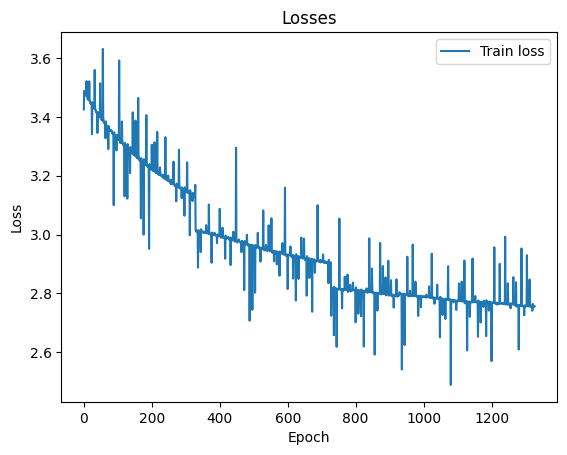

In [ ]:
import matplotlib.pyplot as plt
# load array from file and convert to PyTorch tensor
train_losses = np.loadtxt('saved-text-summarization-train-losses.txt')
#my_tensor = torch.from_numpy(my_array)


def plot_losses(losses1):
    # create a new figure
    plt.figure()

    # plot the first series of losses
    plt.plot(losses1, label='Train loss')

    # plot the second series of losses
    #plt.plot(losses2, label='Val loss')

    # add labels and title to the plot
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses')

    # add a legend to the plot
    plt.legend()

    # display the plot
    plt.show()

plot_losses(train_losses)